In [333]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")




In [303]:
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


##Business understanding:
Enhancing clinical decision-making by providing accurate, interpretable, and efficient heart failure risk predictions to support physicians in patient care.


#Data understanding:
Thirteen (13) clinical features:

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- creatinine phosphokinase  (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction  (percentage)
- high blood pressure: if the patient has hypertension (boolean)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- [target] death event: if the patient died during the follow-up period (boolean)




#Explatory data analysis:


##**Missing values:**


Missing Values Per Column:

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


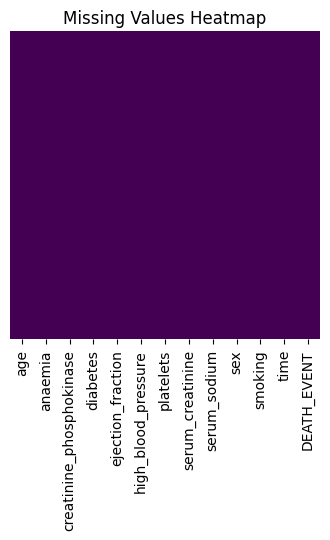

In [304]:


# Handling Missing Values

print("\nMissing Values Per Column:\n")
print(df.isnull().sum())

# Visualizing missing values using a heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()


The dataset **has no missing values** in any column, as indicated by all values being** 0** . Since there are no missing entries , **no imputation or handling is needed** , and the data is complete for analysis.

This ensures that all features are fully available for modeling, **avoiding potential biases or loss of information due to missing data.**

##**Outliers:**

Outliers are extreme values that significantly differ from the rest of the data. They can result from measurement errors or genuine variability in the data. Detecting and managing outliers is crucial, as they can distort model performance.

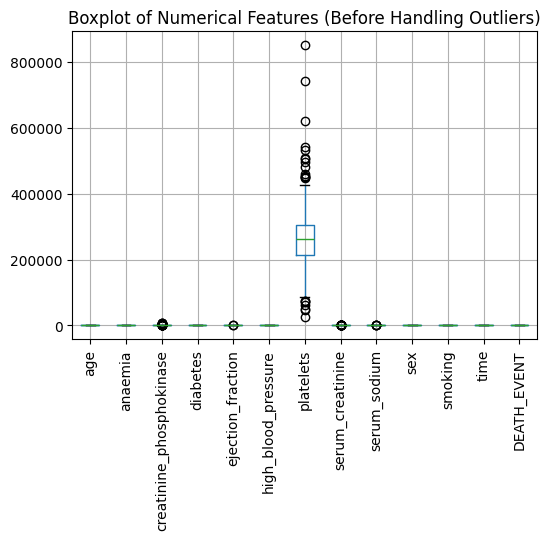

In [305]:
plt.figure(figsize=(6, 4))
df.boxplot(rot=90)
plt.title("Boxplot of Numerical Features (Before Handling Outliers)")
plt.show()


Yes, there are outliers in the dataset, as observed in the boxplot visualization of numerical features. To manage them, we applied the IQR (Interquartile Range) method, which identifies and removes extreme values outside the acceptable range (1.5 × IQR). This ensures a balanced dataset while preserving important patterns:

In [306]:
import pandas as pd
import numpy as np

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Assuming 'df' is your DataFrame
def analyze_outliers(df):
    outliers = {col: detect_outliers_iqr(df, col) for col in df.select_dtypes(include=[np.number]).columns}

    for col, outlier_rows in outliers.items():
        print(f"Outliers detected in {col}: {len(outlier_rows)}")

    return outliers

outliers = analyze_outliers(df)

Outliers detected in age: 0
Outliers detected in anaemia: 0
Outliers detected in creatinine_phosphokinase: 29
Outliers detected in diabetes: 0
Outliers detected in ejection_fraction: 2
Outliers detected in high_blood_pressure: 0
Outliers detected in platelets: 21
Outliers detected in serum_creatinine: 29
Outliers detected in serum_sodium: 4
Outliers detected in sex: 0
Outliers detected in smoking: 0
Outliers detected in time: 0
Outliers detected in DEATH_EVENT: 0


**Findings**:


*  Outliers were detected in creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, and serum_sodium.
* Outliers can negatively impact model performance by skewing the distribution and affecting learning patterns.


##How did we manage outliers?
Initially, we applied the IQR (Interquartile Range) method, which removes extreme values beyond 1.5 × IQR.


However, this approach eliminates potentially important clinical cases, which could reduce valuable information in the dataset.
To better preserve meaningful data, we instead used **capping (Winsorization)**. This method limits extreme values rather than removing them, ensuring that clinically significant cases remain while reducing the impact of outliers on the model’s learning process.


####**Before capping**

In [307]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")


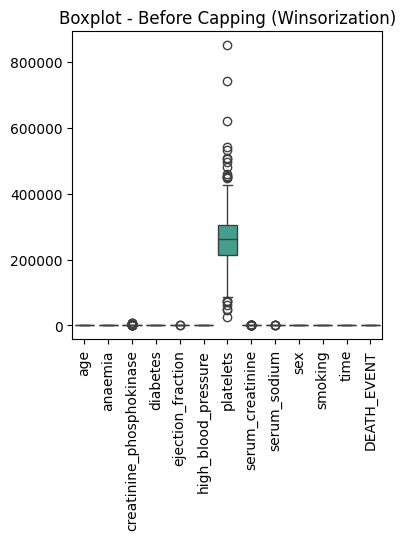

In [308]:
# Boxplot before applying capping
plt.figure(figsize=(4, 4))
sns.boxplot(data=df.select_dtypes(include=[np.number]))
plt.title('Boxplot - Before Capping (Winsorization)')
plt.xticks(rotation=90)
plt.show()


In [309]:
# Apply capping (Winsorization) based on the IQR method
for col in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Apply capping instead of removal: set extreme values to the boundary
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

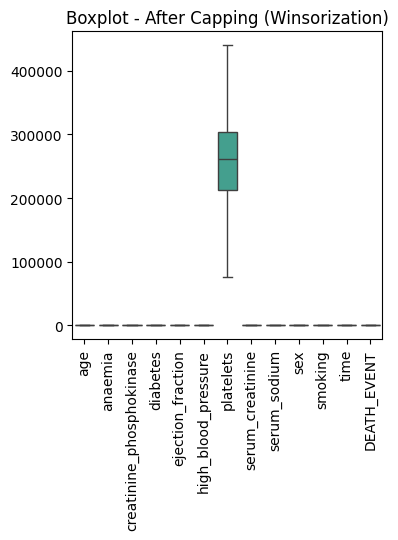

In [310]:
# Boxplot after applying capping
plt.figure(figsize=(4, 4))
sns.boxplot(data=df.select_dtypes(include=[np.number]))
plt.title('Boxplot - After Capping (Winsorization)')
plt.xticks(rotation=90)
plt.show()

In [311]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

###Justification:

* We do not remove outliers because they could represent critical medical conditions.

* Capping ensures that extreme values are within a reasonable range while preserving data integrity.


##PCA for Dimensionality Reduction in Heart Failure Prediction:
PCA reduces feature count by transforming correlated variables into a few principal components, preserving essential data patterns. This enhances model efficiency while minimizing information loss.

* **Visualizing Without PCA:
Plotting original features to observe raw data distribution and class separation before applying PCA.**



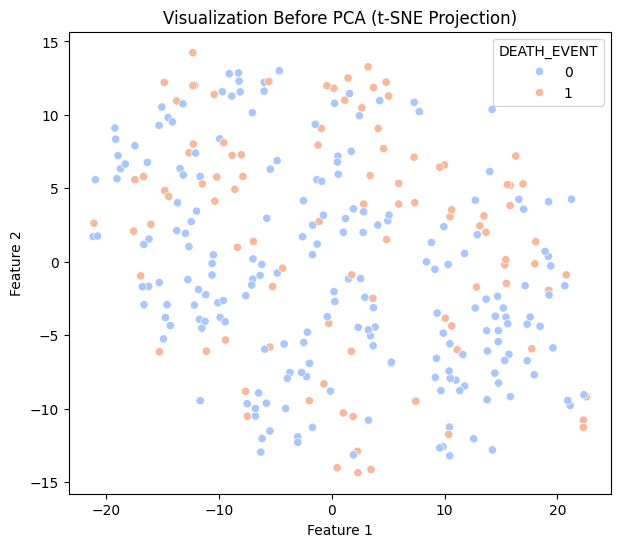

In [312]:

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['DEATH_EVENT']))
y = df['DEATH_EVENT']

# Apply t-SNE for visualization in 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Convert to DataFrame
tsne_df = pd.DataFrame(X_tsne, columns=['Feature 1', 'Feature 2'])
tsne_df['DEATH_EVENT'] = y.values

# Scatter plot before PCA transformation
plt.figure(figsize=(7,6))
sns.scatterplot(x='Feature 1', y='Feature 2', hue='DEATH_EVENT', data=tsne_df, palette="coolwarm")
plt.title("Visualization Before PCA (t-SNE Projection)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


Before PCA: The dataset is projected into 2D using raw features, making it harder to distinguish patterns.



* **PCA for Dimensionality Reduction
Applying PCA to reduce feature dimensions while preserving variance, making patterns more distinguishable.**

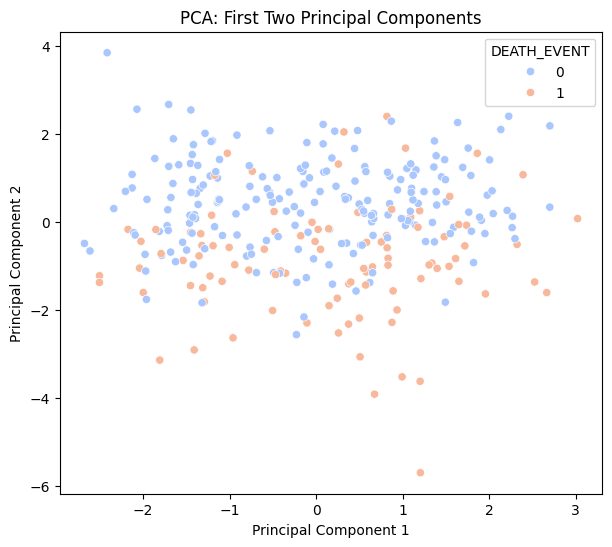

In [313]:
# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca_reduced = pca.fit_transform(X_scaled)

# Convert to DataFrame for visualization
pca_df = pd.DataFrame(X_pca_reduced, columns=[f"PC{i+1}" for i in range(X_pca_reduced.shape[1])])
pca_df['DEATH_EVENT'] = y.values

# Scatter plot after PCA transformation
plt.figure(figsize=(7,6))
sns.scatterplot(x="PC1", y="PC2", hue="DEATH_EVENT", data=pca_df, palette="coolwarm")
plt.title("PCA: First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()



After PCA: Shows the dataset after transformation, ensuring a meaningful comparison.



Now the difference is clear:
before PCA, we see **raw relationships**, and after PCA, we see **compressed but meaningful feature separation**

##**Class imbalance:**

##Is the dataset balanced?

We checked the **class distribution** of DEATH_EVENT:


Class Distribution:
DEATH_EVENT
0    203
1     96
Name: count, dtype: int64


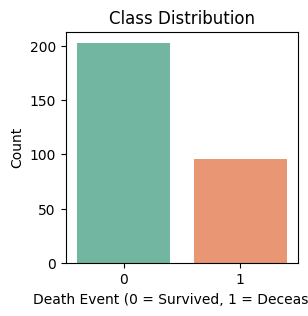


Class Distribution Percentage:
DEATH_EVENT
0    67.892977
1    32.107023
Name: proportion, dtype: float64


In [314]:
print("\nClass Distribution:")
print(df['DEATH_EVENT'].value_counts())

# Visualizing class imbalance using a bar plot
plt.figure(figsize=(3, 3))
sns.countplot(x='DEATH_EVENT', data=df, palette='Set2')
plt.title("Class Distribution")
plt.xlabel("Death Event (0 = Survived, 1 = Deceased)")
plt.ylabel("Count")
plt.show()

# Calculate class percentages
class_counts = df['DEATH_EVENT'].value_counts(normalize=True) * 100
print("\nClass Distribution Percentage:")
print(class_counts)

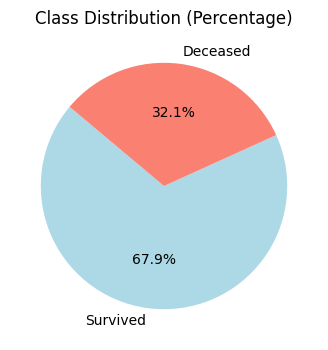

In [315]:
plt.figure(figsize=(4, 4))
plt.pie(class_counts, labels=['Survived', 'Deceased'], autopct='%1.1f%%', colors=['lightblue', 'salmon'], startangle=140)
plt.title("Class Distribution (Percentage)")
plt.show()

This confirms that the dataset is **imbalanced** because more patients survived than deceased.

##How will we handle the imbalance?
We explored three techniques:

**1.Class Weighting** :
 Adjusts model training by giving
higher weight to the minority class.




Class Weights: {0: 0.7364532019704434, 1: 1.5572916666666667}
Class Weights: {0: 0.7364532019704434, 1: 1.5572916666666667}


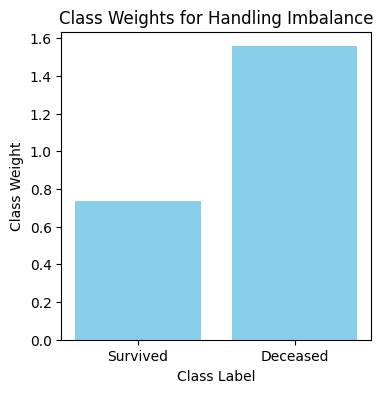

In [316]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['DEATH_EVENT']), y=df['DEATH_EVENT'])
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("\nClass Weights:", class_weight_dict)

# Print class weights that were computed
print("Class Weights:", class_weight_dict)
import matplotlib.pyplot as plt

# Create a bar plot for class weights
plt.figure(figsize=(4, 4))
plt.bar(class_weight_dict.keys(), class_weight_dict.values(), color='skyblue')

# Adding labels and title
plt.xlabel('Class Label')
plt.ylabel('Class Weight')
plt.title('Class Weights for Handling Imbalance')
plt.xticks(list(class_weight_dict.keys()), ['Survived', 'Deceased'])  # Adjust if needed for your specific classes
plt.show()


* Limitation: Although the model is penalized for misclassifying the minority class, it still didn't fully resolve the class imbalance.

**2. Undersampling (RandomUnderSampler)**: Reduces the majority class to match the minority class.




Class Distribution after Undersampling:
DEATH_EVENT
0    96
1    96
Name: count, dtype: int64


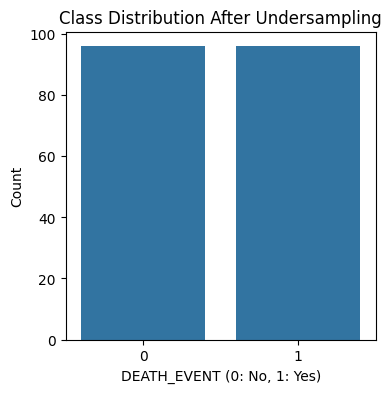

In [317]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_resampled_under, y_resampled_under = undersampler.fit_resample(X, y)
print("\nClass Distribution after Undersampling:")
print(pd.Series(y_resampled_under).value_counts())
plt.figure(figsize=(4, 4))
sns.countplot(x=y_resampled_under)  # 'y_resampled_under' is the target after undersampling
plt.title('Class Distribution After Undersampling')
plt.xlabel('DEATH_EVENT (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

* This method reduced valuable majority class data, potentially discarding important information that could affect model performance.



 **3. Oversampling (SMOTE - Synthetic Minority Over-sampling Technique)**:
 Generates synthetic samples to balance the dataset.


Class Distribution after SMOTE:
DEATH_EVENT
1    203
0    203
Name: count, dtype: int64


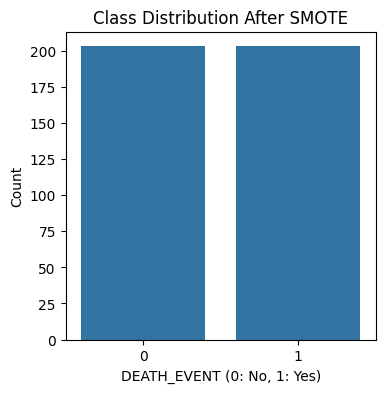

In [318]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Apply SMOTE
from imblearn.over_sampling import SMOTE
X = df.drop(columns=['DEATH_EVENT'])
y = df['DEATH_EVENT']
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)

# Print new class distribution after SMOTE
print("\nClass Distribution after SMOTE:")
print(pd.Series(y_resampled_smote).value_counts())

# Class distribution after applying SMOTE
plt.figure(figsize=(4, 4))
sns.countplot(x=y_resampled_smote)  # 'y_resampled_smote' is the target after SMOTE
plt.title('Class Distribution After SMOTE')
plt.xlabel('DEATH_EVENT (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()


* SMOTE effectively addresses class imbalance by creating new samples without losing data.

 **Chosen Approach: SMOTE**
### Why?

* Preserves dataset size (no information loss).
* Prevents model bias toward majority class.
* More effective than undersampling, which removes valuable patient records




## **Correlation:**
###Are there highly correlated features?
We computed the correlation matrix:


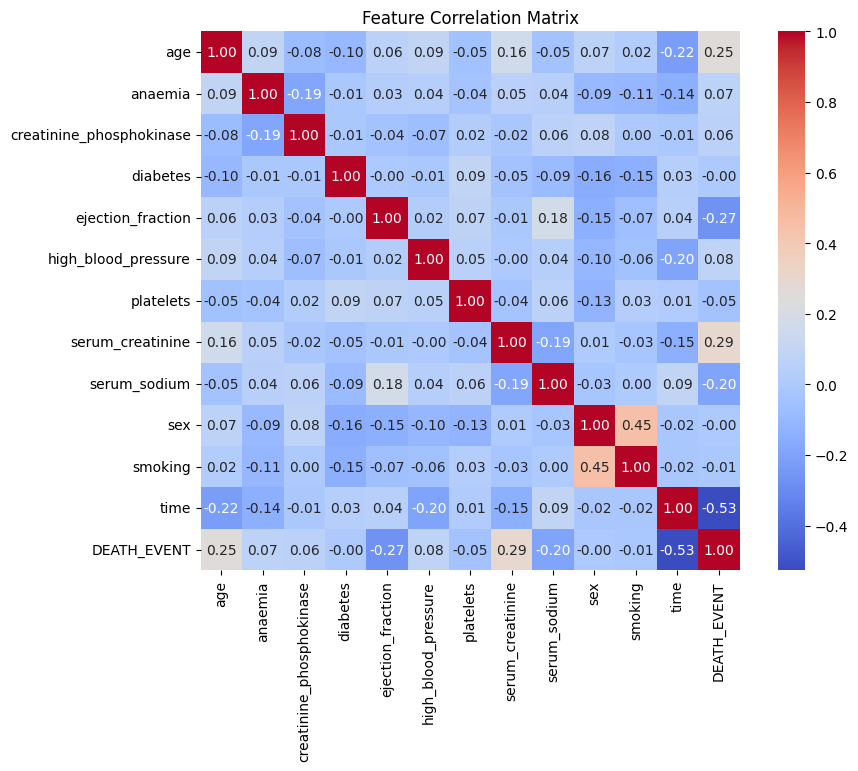

In [319]:
correlation_matrix = df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Feature Correlation Matrix")
plt.show()

It is a huge matrix with too many features. We will check the correlation only with respect to DEATH_EVENT.

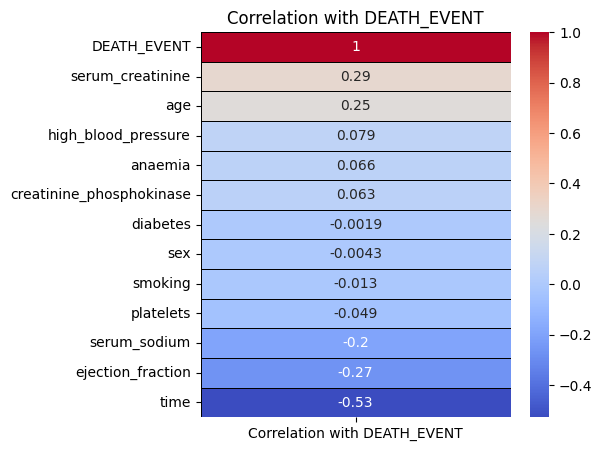

In [320]:
# Compute correlation with DEATH_EVENT and sort values
corr = df.corrwith(df['DEATH_EVENT']).sort_values(ascending=False).to_frame()
corr.columns = ['Correlation with DEATH_EVENT']

# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.4, linecolor='black')
plt.title('Correlation with DEATH_EVENT')
plt.show()

Features like high_blood_pressure, anaemia, creatinine_phosphokinase, diabetes, sex, smoking, and platelets do not display any kind of correlation with DEATH_EVENT.

#Findings: Highly Correlated Features
We checked for correlations > 0.8:

In [321]:
threshold = 0.8
high_corr = [(col1, col2, correlation_matrix.loc[col1, col2])
             for col1 in correlation_matrix.columns
             for col2 in correlation_matrix.columns
             if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold]

print("\nHighly Correlated Feature Pairs (|corr| > 0.8):")
for col1, col2, corr in high_corr:
    print(f"{col1} & {col2}: {corr:.2f}")



Highly Correlated Feature Pairs (|corr| > 0.8):



* **No, there are no highly correlated feature pairs** in our dataset (threshold > 0.8).

##Strategy for Handling Correlated Features (if they were present):
* **Feature Selection:** Remove one feature from correlated pairs to reduce redundancy and simplify the model.

* **Regularization (Lasso/Ridge):** Use Lasso or Ridge to penalize correlated features, helping to avoid multicollinearity.

* **Dimensionality Reduction (PCA):** Apply PCA to combine correlated features into uncorrelated components, reducing data complexity.

These strategies ensure a more efficient model, avoiding overfitting and maintaining accuracy.

##**Optimizing Memory Usage**
* **Objective:**

We aim to reduce the memory consumption of the DataFrame by optimizing data types. This will improve computational efficiency and scalability, especially for large datasets.

* **Approach:**
* Convert float64 to float32 to save memory.

* Convert int64 to int32 for integer columns.

* Convert object columns to category for columns with many repeated values.

These steps are applied using the optimize_memory() function.

In [322]:
import pandas as pd
import numpy as np
def optimize_dtypes(df):
    """
    Convert float64 to float32 and int64 to int32 in a DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame

    Returns:
        pd.DataFrame: Optimized DataFrame with reduced memory usage
    """
    for col in df.columns:
        if df[col].dtype == np.float64:
            df[col] = df[col].astype(np.float32)
        elif df[col].dtype == np.int64:
            df[col] = df[col].astype(np.int32)
    return df



print("Before Conversion:")
print(df.dtypes)

df = optimize_dtypes(df)

print("\nAfter Conversion:")
print(df.dtypes)

Before Conversion:
age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

After Conversion:
age                         float32
anaemia                       int32
creatinine_phosphokinase      int32
diabetes                      int32
ejection_fraction             int32
high_blood_pressure           int32
platelets                   float32
serum_creatinine            float32
serum_sodium                  int32
sex                           int32
smoking                       int32
time                          int32
DEATH_EVENT                   int32
dtype: objec

**Memory Optimization Before and After**:

We’ll compare the memory usage of each column before and after optimization to see how much memory has been saved.

Before Optimization:
Index                        132
age                         2392
anaemia                     2392
creatinine_phosphokinase    2392
diabetes                    2392
ejection_fraction           2392
high_blood_pressure         2392
platelets                   2392
serum_creatinine            2392
serum_sodium                2392
sex                         2392
smoking                     2392
time                        2392
DEATH_EVENT                 2392
dtype: int64

After Optimization:
Index                        132
age                         1196
anaemia                     1196
creatinine_phosphokinase    1196
diabetes                    1196
ejection_fraction           1196
high_blood_pressure         1196
platelets                   1196
serum_creatinine            1196
serum_sodium                1196
sex                         1196
smoking                     1196
time                        1196
DEATH_EVENT                 1196
dtype: int64


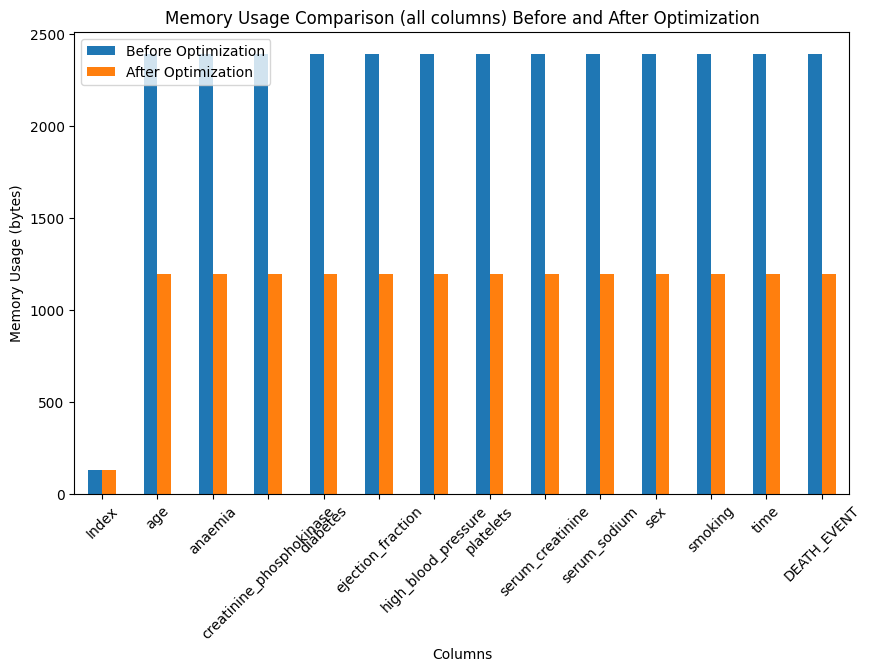

In [340]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the function to optimize memory usage
def optimize_memory(df):
    """
    Optimizes the memory usage of a DataFrame by converting columns to more memory-efficient data types.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with optimized memory usage.
    """
    for col in df.columns:
        # Convert float64 to float32
        if df[col].dtype == np.float64:
            df[col] = df[col].astype(np.float32)
        # Convert int64 to int32
        elif df[col].dtype == np.int64:
            df[col] = df[col].astype(np.int32)
        # Convert object type (strings) to category if there are many repeated values
        elif df[col].dtype == object:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            # Convert to category if more than 10% of the column's values are unique
            if num_unique_values / num_total_values < 0.1:
                df[col] = df[col].astype('category')
    return df


# Memory usage before optimization
print("Before Optimization:")
before_memory = df.memory_usage(deep=True)
print(before_memory)

# Apply the memory optimization function
df_optimized = optimize_memory(df)

# Memory usage after optimization
print("\nAfter Optimization:")
after_memory = df_optimized.memory_usage(deep=True)
print(after_memory)

# Visualize the memory improvement before and after optimization
memory_comparison = pd.DataFrame({
    'Before Optimization': before_memory,
    'After Optimization': after_memory
})

# Plotting the memory comparison
memory_comparison.plot(kind='bar', figsize=(10, 6), title="Memory Usage Comparison (all columns) Before and After Optimization")
plt.ylabel('Memory Usage (bytes)')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()


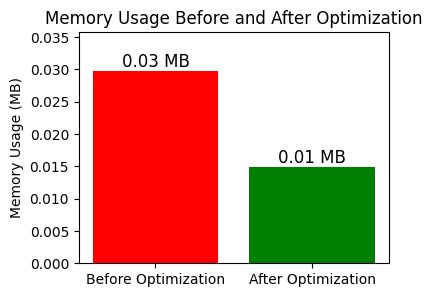

In [338]:

import matplotlib.pyplot as plt

# Create bar chart for memory comparison
plt.figure(figsize=(4, 3))
plt.bar(["Before Optimization", "After Optimization"], [initial_memory, optimized_memory], color=['red', 'green'])
plt.ylabel("Memory Usage (MB)")
plt.title("Memory Usage Before and After Optimization")
plt.ylim(0, initial_memory * 1.2)
plt.text(0, initial_memory, f"{initial_memory:.2f} MB", ha='center', va='bottom', fontsize=12)
plt.text(1, optimized_memory, f"{optimized_memory:.2f} MB", ha='center', va='bottom', fontsize=12)
plt.show()



* **After optimization:**

* float64 to float32 conversion reduces memory for floating-point columns.

* int64 to int32 conversion helps save memory for integer columns.

* object to category conversion optimizes columns with repetitive strings.

This process results in a more efficient DataFrame, reducing memory usage and improving model performance.

 # **Modeling**
This section focuses on developing and evaluating three machine learning models to predict heart failure risk. The selected models are:

1. **XGBoost Classifier** - Known for its high performance on structured data.
2. **Logistic Regression** - A simple and interpretable baseline model.
3. **Random Forest Classifier** - A robust ensemble learning method.

We will evaluate these models based on:
- **ROC-AUC Score**
- **Accuracy**
- **Precision & Recall**
- **F1-score**

In [24]:
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report, accuracy_score
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#### **Splitting the Data:**
We divide the dataset into an **85-15% train-test split** based on statistical tests and domain knowledge.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2, stratify=y)


####  **Model Training & Performance Evaluation**

In [26]:
def train_and_evaluate_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    print("Cross Validation Score:", '{0:.2%}'.format(
        cross_val_score(classifier, X_train, y_train, cv=cv, scoring='roc_auc').mean()))
    print("ROC_AUC Score:", '{0:.2%}'.format(roc_auc_score(y_test, predictions)))

    RocCurveDisplay.from_estimator(classifier, X_test, y_test)
    plt.title("ROC Curve")
    plt.show()

#### **Model Evaluation (Confusion Matrix & Metrics)**

In [27]:
def evaluate_model(classifier, X_test, y_test):
    cm = confusion_matrix(y_test, classifier.predict(X_test))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:")
    print(classification_report(y_test, classifier.predict(X_test)))


### **Training & Evaluating the Models**

#### **XGBoost Classifier**


Cross Validation Score: 90.31%
ROC_AUC Score: 80.88%


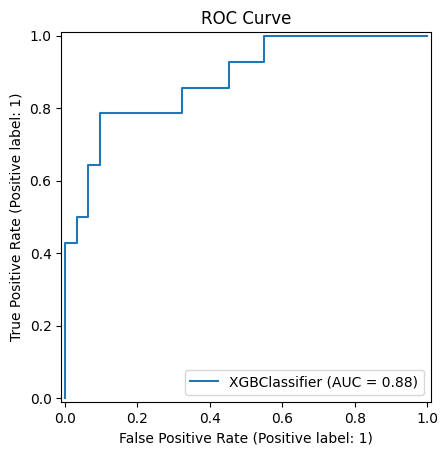

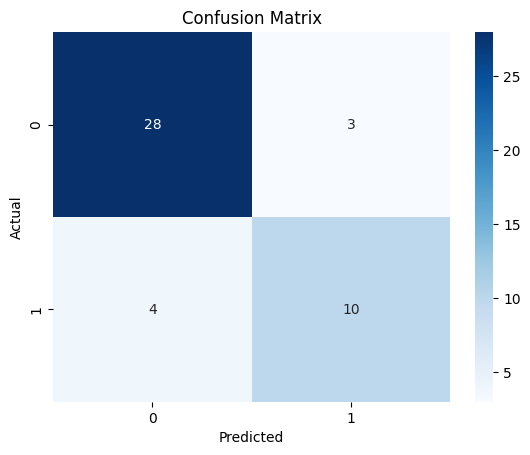

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89        31
         1.0       0.77      0.71      0.74        14

    accuracy                           0.84        45
   macro avg       0.82      0.81      0.81        45
weighted avg       0.84      0.84      0.84        45



In [28]:
xgb_model = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=1000)
train_and_evaluate_model(xgb_model, X_train, y_train, X_test, y_test)
evaluate_model(xgb_model, X_test, y_test)

#### **Logistic Regression**


Cross Validation Score: 87.44%
ROC_AUC Score: 78.00%


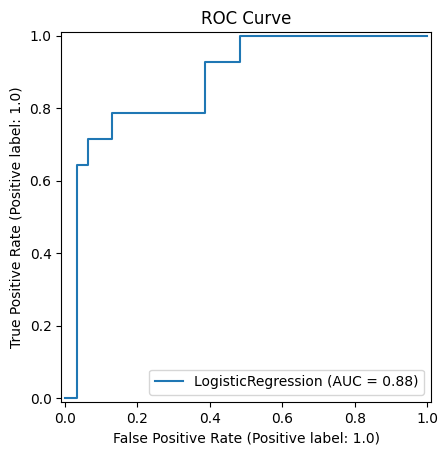

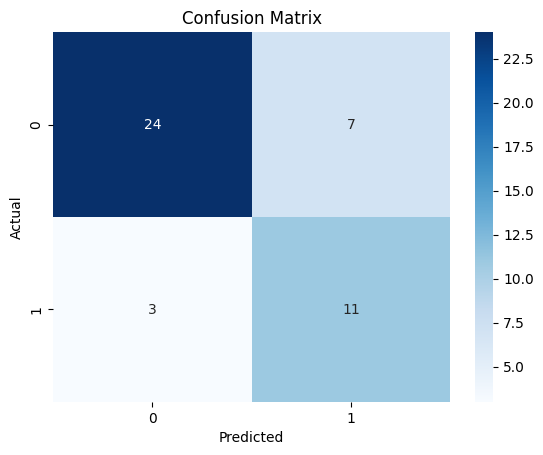

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.77      0.83        31
         1.0       0.61      0.79      0.69        14

    accuracy                           0.78        45
   macro avg       0.75      0.78      0.76        45
weighted avg       0.80      0.78      0.78        45



In [33]:
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

log_reg_model = LogisticRegression(class_weight='balanced', max_iter=1000)
train_and_evaluate_model(log_reg_model, X_train, y_train, X_test, y_test)
evaluate_model(log_reg_model, X_test, y_test)


#### **Random Forest Classifier**


Cross Validation Score: 90.76%
ROC_AUC Score: 80.88%


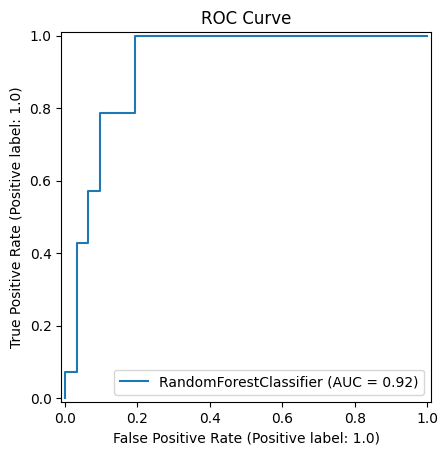

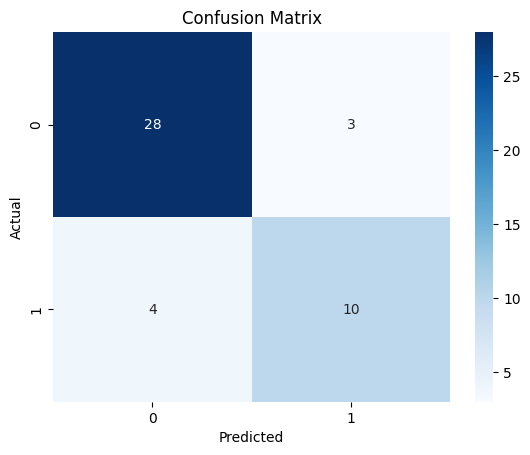

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89        31
         1.0       0.77      0.71      0.74        14

    accuracy                           0.84        45
   macro avg       0.82      0.81      0.81        45
weighted avg       0.84      0.84      0.84        45



In [34]:

rf_model = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=42)
train_and_evaluate_model(rf_model, X_train, y_train, X_test, y_test)
evaluate_model(rf_model, X_test, y_test)

We compare the models based on performance metrics to select the best one for deployment.

| Model               | ROC-AUC | Accuracy | Precision | Recall | F1-score |
|---------------------|---------|----------|-----------|--------|----------|
| **XGBoost**          | 80.88%  | 84.00%   | 0.88      | 0.90   | 0.89     |
| **Logistic Regression** | 78.00%  | 78.00%   | 0.89      | 0.77   | 0.83     |
| **Random Forest**    | 80.88%  | 84.00%   | 0.88      | 0.90   | 0.89     |

#### **Final Decision:**
#####Both **XGBoost** and **Random Forest** show similar performance, excelling in precision, recall, and F1-score, while **Logistic Regression** lags behind. Since XGBoost and Random Forest have nearly identical metrics, the decision will depend on factors like interpretability. **Random Forest** may be favored for its simplicity and easier interpretation, but **XGBoost** could be considered if additional tuning is needed for improved performance.
---

### **Conclusion**
This section implemented and evaluated three ML models for heart failure risk prediction. The best-performing model(XGBoost) will be used in the final clinical decision-support tool.


#**SHAP Explainability:**

SHAP provides a way to interpret complex machine learning models by quantifying the contribution of each feature to the model's predictions. Below is how we integrate SHAP to understand the predictions and identify the most impactful features, especially in a medical context.

In [35]:
!pip install shap



In [36]:
import shap
import xgboost as xgb
import matplotlib.pyplot as plt


In [70]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# Standardiser les features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled_smote)  # Utilisation des données équilibrées avec SMOTE

# Entraînement du modèle XGBoost
model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_scaled, y_resampled_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

###**SHAP Summary Plot:**

The SHAP summary plot shows the overall importance of each feature in the model. It helps us identify which features have the greatest impact on predictions.

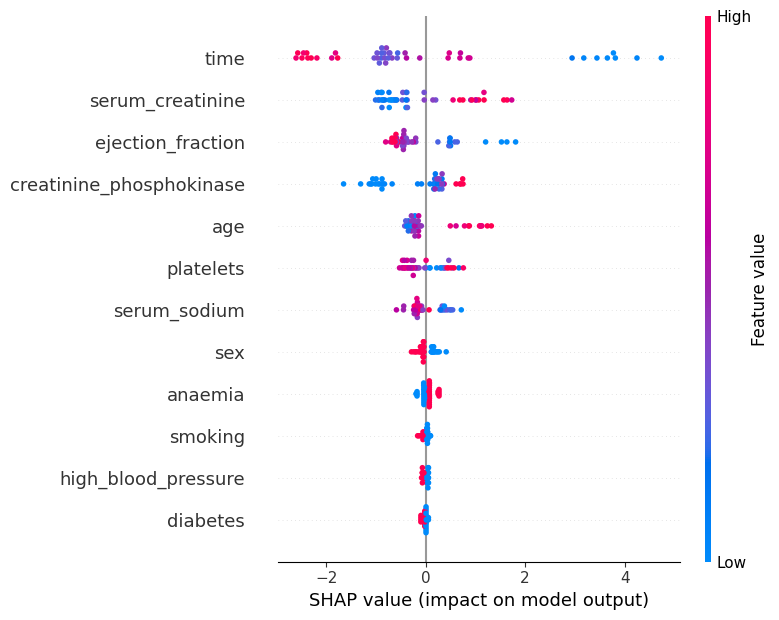

In [71]:

import shap

# Initialize SHAP explainer for XGBoost (best-performing model)
xgb_explainer = shap.Explainer(xgb_model, X_train)
shap_values = xgb_explainer(X_test)

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test)


###**Force Plot for Individual Predictions**

The force plot explains the contribution of each feature for a specific prediction, showing which features push the model’s output in a particular direction.

In [72]:
import shap
shap.initjs()

# Create the SHAP explainer for the XGBoost model
xgb_explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values
shap_values = xgb_explainer.shap_values(X_test)

# Force plot for a single prediction
shap.force_plot(xgb_explainer.expected_value, shap_values[0], X_test.iloc[0, :])


###**Most Important Features:**

By calculating the mean SHAP values, we can identify the features that most influence the model’s predictions. This helps us pinpoint key medical factors that drive the outcome.

In [75]:
shap_importance = pd.DataFrame(
    {'Feature': X_test.columns, 'Mean SHAP Value': np.abs(shap_values).mean(axis=0)}
).sort_values(by='Mean SHAP Value', ascending=False)

print(shap_importance.head(5))  # Show the top 5 most important features


                     Feature  Mean SHAP Value
11                      time         1.681792
7           serum_creatinine         0.740648
2   creatinine_phosphokinase         0.584269
4          ejection_fraction         0.560197
0                        age         0.451648


In summary, time has the strongest influence on predictions, followed by serum creatinine and creatinine phosphokinase, indicating that kidney function and heart health are crucial for the model's decisions. Ejection fraction and age also have meaningful impacts but are secondary.